In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nlpde_solver

# Explanation

Demo of the code we used for all the simulations in the paper. 

The equation we solve is 
$$ \partial_t u = -\partial_x \left( -D \partial_x u + u p(u) \left[ \chi_p \mathcal{A} (u) + \chi_b B(x) \right]\right)$$
with
$$ \mathcal{A}(u) = \int_0^L \tilde g_p(x'-x) u(x') dx, \qquad B(x) = \int_{\mathbb{R}\backslash [0,L]} g_b(x'-x) dx$$
and $g_p$ and $g_b$ are the interaction kernels used for the particle-particle and particle-boundary interactions.

The function $p$ is the `packing function', used to model volume exclusion. We use $p(u) = 1- u/K$ here. 

## Numerical method

All functions are in the file `nlpde_solver'.

We do a spatial discretization of the equation using the finite volume method. This makes the numerical scheme automatically mass-conserving and allows a simple implementation of no-flux boundary conditions. 

Computation of the nonlocal term (essentially, a convolution) is done using fast Fourier transforms. However, these require a periodic domain. We thus embed the interval $[0, L]$ in a larger domain $[-R, L+R]$, where $R$ is the cutoff we use for computing the long-range interaction. When then compute the convolution on this larger domain, but make sure to at each step set the field $u$ to zero outside of $[0, L]$. 

Timestepping is done using scipy's solve_ivp method. We normally use the `BDF' solver.

## Implementation

We embed everything in a 'Solve' object, which includes parameters etc. To prepare for solving, we need to call the 'prepsolve' function, which prepares the matrices needed for the FFTs. Doing the timestepping is done using the 'solve' function. After this, the timepoints, spatial points and the values of u are stored in attributes of the solver object. 

## Remarks
- Due to historical reasons, some variable names are different in the code than in the paper. For example $\chi_p = \chi_0$ and $K=\rho_\textup{max}$.
- The code in `nlpde_solver' allows to solve a more general equation (with an added reaction term and a pressure-like term), which we don't use in the paper but is left in the code.
- The code also includes a class to solver the equation on a periodic domain.  
- In the paper we usually use scaled units --- this would mean setting $\sigma=1, D=1, K=1$. Then $\chi_0$ corresponds to the parameter $\alpha$. 

-----------------
## Example

In [2]:
### set the interaction kernel
g = lambda x: np.exp(-x)


#### let's use scaled units
sigma=1
K=1
D=1

alpha=20
#### boundary interaction: neutral

u00 = 0.4 ### this is the rho0, average density
beta = u00*alpha ## neutral boundary interactions

solver = nlpde_solver.Solver1DBoundary(D = D, K=K, chi0=alpha, sigma=sigma, g=g, \
                                   sigmab=sigma, gb=g, chib=beta)

## domain length (normalized, units of sigma)
L=4

#### precompute some of the things for the FFT etc.
solver.prepsolve(L=L, N=200, R=L,Rb=L,phiN=2, correct=True)

### solve with random initial conditions
u0 = u00 + np.random.normal(size=solver.xx.shape)*0.1
## remove any negative values and rescale such that the average density is still u00
u0[u0<0]=0. # remove negative values
# make sure total density is still rho0
dx = solver.xx[1]-solver.xx[0]
u0 = u0/np.sum(u0)/dx*u00*L

solver.solve(T = 4, dt=.1, u0=u0, save_every=1, method='scipyBDF')

/home/jan/Documents/Work/01_Research/segmentationclock/theorypaper_new/code_to_share/nlpde_solver.py:291: ComplexWarning: Casting complex values to real discards the imaginary part
  Fdiff[Nb-1] = -Fadv[Nb-1]
/home/jan/Documents/Work/01_Research/segmentationclock/theorypaper_new/code_to_share/nlpde_solver.py:292: ComplexWarning: Casting complex values to real discards the imaginary part
  Fdiff[-Nb] = -Fadv[-Nb]
/home/jan/miniforge3/envs/science/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


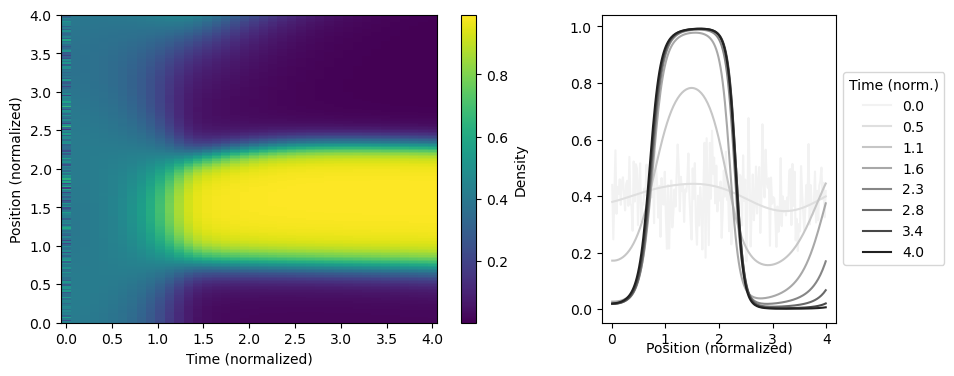

In [3]:
## Make some plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), width_ratios=[2, 1])

#### left: kymograph
pp=axes[0].pcolormesh(solver.tt, solver.xx, solver.uu.T)
fig.colorbar(pp, label='Density')
axes[0].set_xlabel("Time (normalized)")
axes[0].set_ylabel("Position (normalized)")

## right: some snapshots
nsnapshots = 8
for j, f in enumerate(np.linspace(0, len(solver.tt)-1, nsnapshots).astype(int)):
    axes[1].plot(solver.xx, solver.uu[f], color=plt.cm.Greys((j+1)/(nsnapshots+1)), label='{:.1f}'.format(solver.tt[f]))

axes[1].set_xlabel('Position (normalized)', labelpad=-4)
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Time (norm.)')